In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
#import warnings
from scipy import stats
from scipy.stats import norm, skew

from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor

from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

#warnings.filterwarnings(action='ignore', module='scipy', message='^internal gelsd')

%matplotlib inline

# Нека първо да разгледаме и анализираме данните

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.shape, test.shape

((1460, 81), (1459, 80))

In [4]:
n = train.shape[0]

Нека веднага проверим за корелация между атрибути

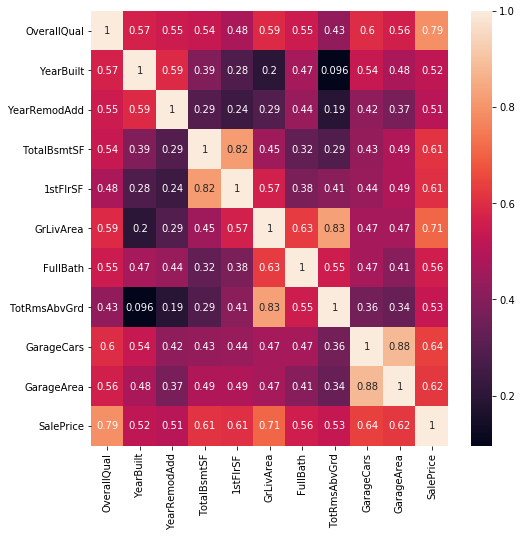

In [5]:
corr_matrix = train.corr()
top_corr_features = corr_matrix.index[abs(corr_matrix["SalePrice"])>0.5]
plt.figure(figsize=(8,8))
g = sns.heatmap(train[top_corr_features].corr(),annot=True)

На последния ред може да видим корелацията между целевия атрибут и атрибутите, които корелират най-силно с него.

Ще визуализираме разпредлението между целевия атрибут и най-силно корелираните с него, като ще премахваме и outliers.

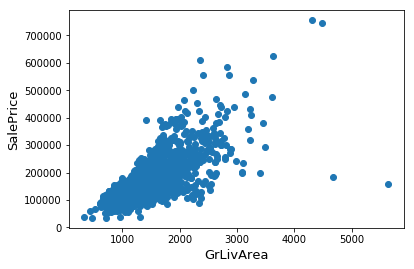

In [6]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

Тук се забелязват outliers

In [7]:
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

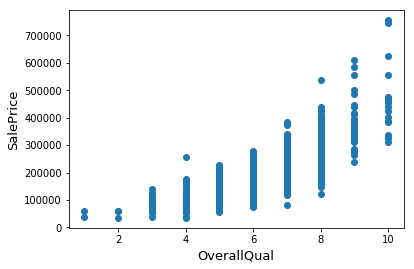

In [8]:
fig, ax = plt.subplots()
ax.scatter(x = train['OverallQual'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('OverallQual', fontsize=13)
plt.show()

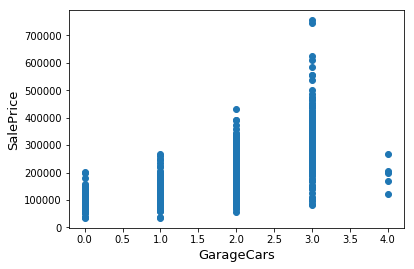

In [9]:
fig, ax = plt.subplots()
ax.scatter(x = train['GarageCars'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GarageCars', fontsize=13)
plt.show()

Като че ли, последната колона показва наличие на outliers. 

In [10]:
train[train['GarageCars'] == 4]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
420,421,90,RM,78.0,7060,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,11,2008,WD,Alloca,206300
747,748,70,RM,65.0,11700,Pave,Pave,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2009,WD,Normal,265979
1190,1191,190,RL,NaN,32463,Pave,NaN,Reg,Low,AllPub,...,0,NaN,NaN,NaN,0,3,2007,WD,Normal,168000
1340,1341,20,RL,70.0,8294,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdWo,NaN,0,6,2007,WD,Normal,123000
1350,1351,90,RL,91.0,11643,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2009,WD,Normal,200000


Имаме само 5 записа, в които 'GarageCars' е 4, затова ще ги изтрием.

In [11]:
train = train.drop(train[train['GarageCars'] == 4].index)

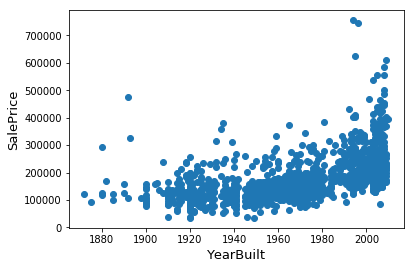

In [12]:
fig, ax = plt.subplots()
ax.scatter(x = train['YearBuilt'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('YearBuilt', fontsize=13)
plt.show()

Логиката, а и графиката показват, че по-новите къщи струват повече, затова старите скъпи къщи ще ги сметнем за outliers и ще ги изтрием.

In [13]:
train = train.drop(train[(train['YearBuilt'] < 1910) & (train['SalePrice'] > 250000)].index)

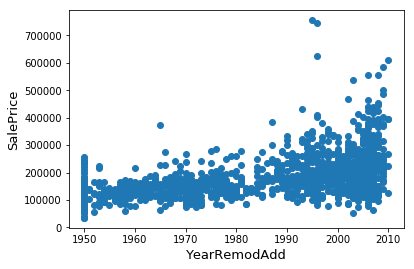

In [14]:
fig, ax = plt.subplots()
ax.scatter(x = train['YearRemodAdd'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('YearRemodAdd', fontsize=13)
plt.show()

In [15]:
train[(train['YearRemodAdd'] == 1965) & (train['SalePrice'] > 160000)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
313,314,20,RL,150.0,215245,Pave,NaN,IR3,Low,AllPub,...,0,NaN,NaN,NaN,0,6,2009,WD,Normal,375000
335,336,190,RL,NaN,164660,Grvl,NaN,IR1,HLS,AllPub,...,0,NaN,NaN,Shed,700,8,2008,WD,Normal,228950


In [16]:
train = train.drop(train[(train['YearRemodAdd'] == 1965) & (train['SalePrice'] > 160000)].index)

In [17]:
train = train.drop(train[(train['YearRemodAdd'] < 1970) & (train['SalePrice'] > 300000)].index)
train = train.drop(train[(train['YearRemodAdd'] < 2000) & (train['SalePrice'] > 500000)].index)

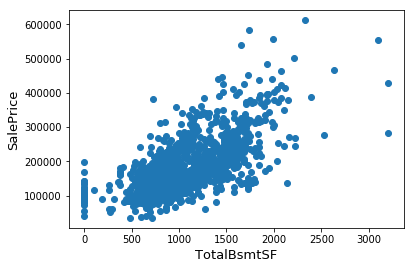

In [18]:
fig, ax = plt.subplots()
ax.scatter(x = train['TotalBsmtSF'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('TotalBsmtSF', fontsize=13)
plt.show()

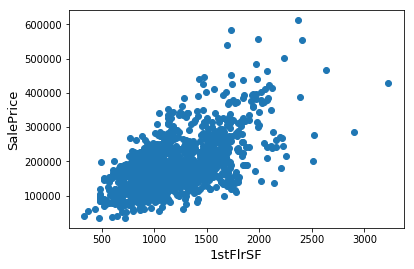

In [19]:
fig, ax = plt.subplots()
ax.scatter(x = train['1stFlrSF'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('1stFlrSF', fontsize=13)
plt.show()

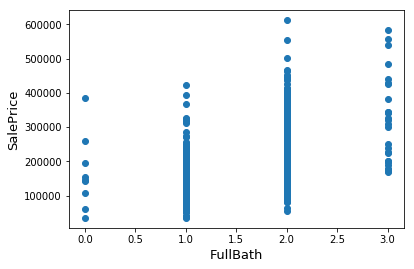

In [20]:
fig, ax = plt.subplots()
ax.scatter(x = train['FullBath'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('FullBath', fontsize=13)
plt.show()

In [21]:
train = train.drop(train[(train['FullBath'] == 0) & (train['SalePrice'] > 350000)].index)

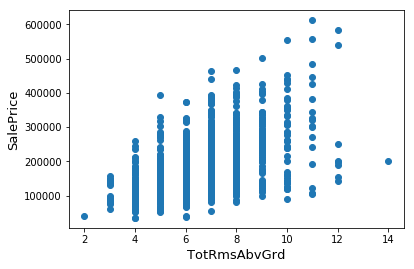

In [22]:
fig, ax = plt.subplots()
ax.scatter(x = train['TotRmsAbvGrd'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('TotRmsAbvGrd', fontsize=13)
plt.show()

In [23]:
train = train.drop(train[(train['TotRmsAbvGrd'] == 14) & (train['SalePrice'] < 250000)].index)

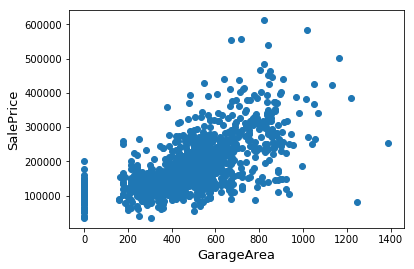

In [24]:
fig, ax = plt.subplots()
ax.scatter(x = train['GarageArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GarageArea', fontsize=13)
plt.show()

In [25]:
train = train.drop(train[(train['GarageArea'] > 1200) & (train['SalePrice'] < 300000)].index)

In [26]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1441.000000,1441.000000,1184.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1433.000000,1441.000000,...,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.00000,1441.000000,1441.000000,1441.000000,1441.00000
mean,730.430951,56.637752,69.470439,10117.902845,6.081194,5.571825,1971.436502,1984.815406,101.480809,435.359473,...,92.787647,45.918112,21.975711,3.454545,14.975017,2.07703,43.188064,6.321305,2007.818876,179107.33796
std,421.708492,42.063402,22.932312,7099.245041,1.355928,1.105170,29.937486,20.684853,174.590634,427.041102,...,122.407610,64.200934,60.718854,29.507476,55.124853,35.56696,498.877455,2.701882,1.331699,75131.98309
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,2006.000000,34900.00000
25%,366.000000,20.000000,59.000000,7500.000000,5.000000,5.000000,1954.000000,1966.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,5.000000,2007.000000,129900.00000
50%,732.000000,50.000000,69.000000,9430.000000,6.000000,5.000000,1973.000000,1994.000000,0.000000,381.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.00000,0.000000,6.000000,2008.000000,162000.00000
75%,1094.000000,70.000000,80.000000,11475.000000,7.000000,6.000000,2001.000000,2004.000000,164.000000,705.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.00000,0.000000,8.000000,2009.000000,213000.00000
max,1460.000000,190.000000,313.000000,159000.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,2188.000000,...,736.000000,547.000000,552.000000,508.000000,480.000000,738.00000,15500.000000,12.000000,2010.000000,611657.00000


In [27]:
test.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1459.000000,1459.000000,1232.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1444.000000,1458.000000,...,1458.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,2190.000000,57.378341,68.580357,9819.161069,6.078821,5.553804,1971.357779,1983.662783,100.709141,439.203704,...,472.768861,93.174777,48.313914,24.243317,1.794380,17.064428,1.744345,58.167923,6.104181,2007.769705
std,421.321334,42.746880,22.376841,4955.517327,1.436812,1.113740,30.390071,21.130467,177.625900,455.268042,...,217.048611,127.744882,68.883364,67.227765,20.207842,56.609763,30.491646,630.806978,2.722432,1.301740
min,1461.000000,20.000000,21.000000,1470.000000,1.000000,1.000000,1879.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,1825.500000,20.000000,58.000000,7391.000000,5.000000,5.000000,1953.000000,1963.000000,0.000000,0.000000,...,318.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,2190.000000,50.000000,67.000000,9399.000000,6.000000,5.000000,1973.000000,1992.000000,0.000000,350.500000,...,480.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,2554.500000,70.000000,80.000000,11517.500000,7.000000,6.000000,2001.000000,2004.000000,164.000000,753.500000,...,576.000000,168.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,2919.000000,190.000000,200.000000,56600.000000,10.000000,9.000000,2010.000000,2010.000000,1290.000000,4010.000000,...,1488.000000,1424.000000,742.000000,1012.000000,360.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


От последните 2 клетки, освен средното, минималната и максималната стойности, стандартното отклонение и трите квартила за всеки атрибут, то може да забележим, че по-голямата част от атрибутите са категорийни.

In [28]:
train.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


In [29]:
test.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
5,1466,60,RL,75.0,10000,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal
6,1467,20,RL,NaN,7980,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,GdPrv,Shed,500,3,2010,WD,Normal
7,1468,60,RL,63.0,8402,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal
8,1469,20,RL,85.0,10176,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2010,WD,Normal
9,1470,20,RL,70.0,8400,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,4,2010,WD,Normal


Веднага се забелязва наличието на много липсващи стойности за някои от атрибутите. Нека по-обстойно да проверим точно това.

In [30]:
nan_frame = pd.concat([train.isnull().sum(), test.isnull().sum()], axis=1, keys=['Train', 'Test'])
nan_frame[nan_frame.sum(axis=1) > 0]

/home/iliyan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,Train,Test
Alley,1352,1352.0
BsmtCond,37,45.0
BsmtExposure,38,44.0
BsmtFinSF1,0,1.0
BsmtFinSF2,0,1.0
BsmtFinType1,37,42.0
BsmtFinType2,38,42.0
BsmtFullBath,0,2.0
BsmtHalfBath,0,2.0
BsmtQual,37,44.0


Забелязваме, че и в трейн сета, и в тест сета липсващите стойности са за съотвени колони. Атрибутите с по над половината липсващи стойности направо ги изтриваме. Това са "Alley", "Fence", "MiscFeature", "PoolQC" и 'FireplaceQu'.

In [31]:
train_copied = train.drop(columns = ['Alley', 'Fence', 'MiscFeature', 'PoolQC', 'FireplaceQu'], axis=1)
test_copied = test.drop(columns = ['Alley', 'Fence', 'MiscFeature', 'PoolQC', 'FireplaceQu'], axis=1)

In [32]:
train_copied.shape, test_copied.shape

((1441, 76), (1459, 75))

In [33]:
#всъщност нямаме нужда от колона за id
train_id = train_copied['Id']
test_id = test_copied['Id']

train_copied.drop("Id", axis = 1, inplace = True)
test_copied.drop("Id", axis = 1, inplace = True)

За да обработим липсващите стойности ще конкатенираме двата дейта сета.

In [34]:
y = train_copied.SalePrice.values
all_data = pd.concat((train_copied, test_copied)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)

all_data.shape

/home/iliyan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


(2900, 74)

Атрибутът "LotFrontage" е с 257 липсващи стойности в трейн сета и с 227 в тест сета, т.е. по около 20% липсващи стойности за този атрибут и в 2-та дейта сета. 

In [35]:
# ще групираме по квартали и ще запълним с медианната стойност
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

За всички останали атрибути количеството липсващи стойности е 5% или под 5%, затова ще ги запълним с най-често срещаната стойност/средна стойност/медиана в зависимост от самия атрибут.

In [36]:
# използвайки информацията от description-а на дейта сета, за следващите 4 фийчъра заменяме 'na' стойностите с None
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'] : all_data[col] = all_data[col].fillna('None')

In [37]:
# аналогично тук
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars') : all_data[col] = all_data[col].fillna(0)

In [38]:
# и тук
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

In [39]:
# използвайки пак информацията от описанието NaN стойност в атрбиут за мазе означава, че такова липсва
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

In [40]:
# за атрибутите 'MasVnrArea' и 'MasVnrType' нямам информация какво означават na стойностите, 
# затова ще ги запълним с най-често срещаната стойност и средното

all_data['MasVnrType'] = all_data['MasVnrType'].fillna(all_data['MasVnrType'].mode()[0])
all_data['MasVnrArea'] = all_data['MasVnrArea'].fillna(all_data['MasVnrArea'].mean())

In [41]:
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

In [42]:
all_data['Utilities'].value_counts()

AllPub    2897
NoSeWa       1
Name: Utilities, dtype: int64

In [43]:
# този атрибут не ни носи информация и направо може да се изтрие 
all_data = all_data.drop(['Utilities'], axis=1)

In [44]:
all_data["Functional"] = all_data["Functional"].fillna("Typ")

In [45]:
cols = ['Electrical','KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType', 'Functional']
for col in cols:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

In [46]:
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [47]:
sum(all_data.isnull().sum())

0

Нека видим какво е разпределението на целевия атрибут

/home/iliyan/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


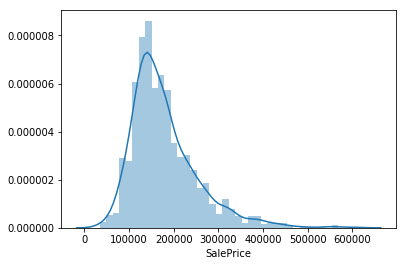

In [48]:
sns.distplot(train['SalePrice'])

Забелязва се Right-Skewed разпределение.


 mu = 179107.34 and sigma = 75105.91



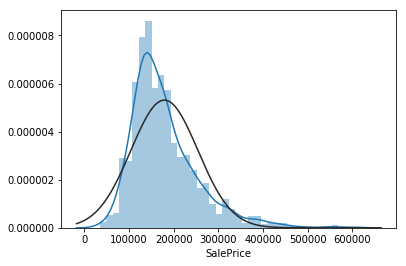

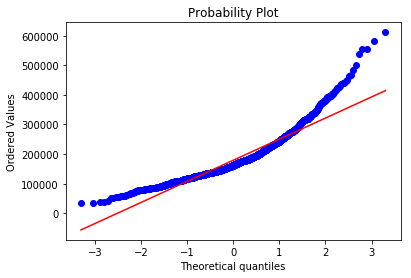

In [49]:
def check_skewness(col):
    sns.distplot(train_copied[col] , fit=norm);
    fig = plt.figure()
    res = stats.probplot(train_copied[col], plot=plt)
    # Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(train_copied[col])
    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
    
check_skewness('SalePrice')

Най-добрият начин да го оправим е чрез логаритмуване


 mu = 12.02 and sigma = 0.39



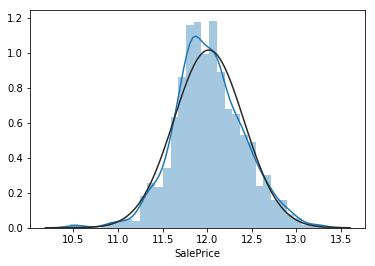

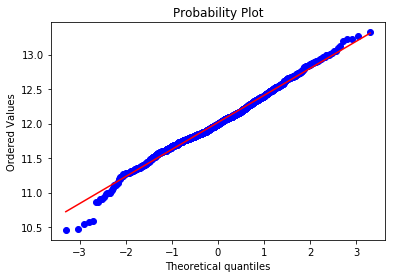

In [50]:
train_copied["SalePrice"] = np.log1p(train_copied["SalePrice"])

check_skewness('SalePrice')

In [51]:
train_copied['GrLivArea'] = np.log1p(train_copied['GrLivArea'])

Някои от атрибутите са категорийни с категории от 0 до 9, затова трябва да контвертираме тези стойности до стрингове.

In [52]:
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
all_data['OverallCond'] = all_data['OverallCond'].astype(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

Превръщаме категорийните атрибути в непрекъснати

In [53]:
categorial = all_data.select_dtypes(include = ["object"]).columns
categorial

Index(['BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'BsmtQual', 'CentralAir', 'Condition1', 'Condition2', 'Electrical',
       'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'Foundation',
       'Functional', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType',
       'Heating', 'HeatingQC', 'HouseStyle', 'KitchenQual', 'LandContour',
       'LandSlope', 'LotConfig', 'LotShape', 'MSSubClass', 'MSZoning',
       'MasVnrType', 'MoSold', 'Neighborhood', 'OverallCond', 'PavedDrive',
       'RoofMatl', 'RoofStyle', 'SaleCondition', 'SaleType', 'Street',
       'YrSold'],
      dtype='object')

In [54]:
all_data_orig = all_data.copy()

In [55]:
train = all_data[:1441]

train_dummy = pd.get_dummies(train)
train_dummy.shape

(1441, 312)

In [56]:
train_dummy.head(10)

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,...,SaleType_New,SaleType_Oth,SaleType_WD,Street_Grvl,Street_Pave,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010
0,856,854,0,3,706.0,0.0,1.0,0.0,150.0,0,...,0,0,1,0,1,0,0,1,0,0
1,1262,0,0,3,978.0,0.0,0.0,1.0,284.0,0,...,0,0,1,0,1,0,1,0,0,0
2,920,866,0,3,486.0,0.0,1.0,0.0,434.0,0,...,0,0,1,0,1,0,0,1,0,0
3,961,756,0,3,216.0,0.0,1.0,0.0,540.0,272,...,0,0,1,0,1,1,0,0,0,0
4,1145,1053,0,4,655.0,0.0,1.0,0.0,490.0,0,...,0,0,1,0,1,0,0,1,0,0
5,796,566,320,1,732.0,0.0,1.0,0.0,64.0,0,...,0,0,1,0,1,0,0,0,1,0
6,1694,0,0,3,1369.0,0.0,1.0,0.0,317.0,0,...,0,0,1,0,1,0,1,0,0,0
7,1107,983,0,3,859.0,32.0,1.0,0.0,216.0,228,...,0,0,1,0,1,0,0,0,1,0
8,1022,752,0,2,0.0,0.0,0.0,0.0,952.0,205,...,0,0,1,0,1,0,0,1,0,0
9,1077,0,0,2,851.0,0.0,1.0,0.0,140.0,0,...,0,0,1,0,1,0,0,1,0,0


In [57]:
categorial1 = train_dummy.select_dtypes(include = ["object"]).columns
categorial1

Index([], dtype='object')

In [58]:
X_train, X_test, y_train, y_test = train_test_split(train_dummy, y, test_size=0.15, random_state = 42)

In [59]:
alpha = [0.001, 0.01, 0.1, 1, 2, 5, 10, 20, 30, 40, 50, 90, 100]

for a in alpha:
    all_data_lr = Ridge(alpha=a).fit(X_train, y_train)
    print("alpha: ", a)
    print(all_data_lr.score(X_train, y_train), all_data_lr.score(X_test, y_test))
    print()

alpha:  0.001
0.9447681072303479 0.8927680796371604

alpha:  0.01
0.9447642649081393 0.8934265400273761

alpha:  0.1
0.9446181510708254 0.8961248553998784

alpha:  1
0.9436777337631369 0.8987788053737436

alpha:  2
0.9430513436409063 0.8997468437770763

alpha:  5
0.941586657981084 0.9016662978571568

alpha:  10
0.9395220199333828 0.9034354496027013

alpha:  20
0.936059277539567 0.9046672032172252

alpha:  30
0.9331988031569868 0.904727093844186

alpha:  40
0.9307526125264687 0.9043586696389514

alpha:  50
0.9286054130464249 0.9038107247715307

alpha:  90
0.9218432348058874 0.9011844411544252

alpha:  100
0.9204520953997746 0.900521696739948



In [60]:
alpha = [0.001, 0.01, 0.1, 1, 2, 5, 10, 20, 30, 40, 50, 90, 100]

for a in alpha:
    all_data_lr = Lasso(alpha=a).fit(X_train, y_train)
    print("alpha: ", a)
    print(all_data_lr.score(X_train, y_train), all_data_lr.score(X_test, y_test))
    print()

/home/iliyan/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha:  0.001
0.9447367389362744 0.8929870704970174



/home/iliyan/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha:  0.01
0.9447366541191329 0.8927243750701206



/home/iliyan/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha:  0.1
0.9447360188624714 0.8921517896588025



/home/iliyan/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha:  1
0.9447083966006193 0.8942158142597114



/home/iliyan/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha:  2
0.9446405465518265 0.8954551930968989



/home/iliyan/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha:  5
0.944319881492185 0.8983699432510024



/home/iliyan/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha:  10
0.9436280377783759 0.900371081732633



/home/iliyan/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha:  20
0.94220948514927 0.9009347105140003



/home/iliyan/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha:  30
0.9409583061508333 0.9024628228308881



/home/iliyan/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha:  40
0.940018440384907 0.9037884503846164



/home/iliyan/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha:  50
0.9391951403436339 0.9048221748427652



/home/iliyan/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha:  90
0.9359601098761872 0.9059005577273427

alpha:  100
0.935050217027472 0.9058625174654481



/home/iliyan/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [61]:
new_train = all_data_orig[:1441]

In [62]:
new_train.head(10)

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,...,SaleCondition,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,3,1Fam,TA,No,706.0,0.0,GLQ,...,Normal,WD,0,Pave,8,856.0,0,2003,2003,2008
1,1262,0,0,3,1Fam,TA,Gd,978.0,0.0,ALQ,...,Normal,WD,0,Pave,6,1262.0,298,1976,1976,2007
2,920,866,0,3,1Fam,TA,Mn,486.0,0.0,GLQ,...,Normal,WD,0,Pave,6,920.0,0,2001,2002,2008
3,961,756,0,3,1Fam,Gd,No,216.0,0.0,ALQ,...,Abnorml,WD,0,Pave,7,756.0,0,1915,1970,2006
4,1145,1053,0,4,1Fam,TA,Av,655.0,0.0,GLQ,...,Normal,WD,0,Pave,9,1145.0,192,2000,2000,2008
5,796,566,320,1,1Fam,TA,No,732.0,0.0,GLQ,...,Normal,WD,0,Pave,5,796.0,40,1993,1995,2009
6,1694,0,0,3,1Fam,TA,Av,1369.0,0.0,GLQ,...,Normal,WD,0,Pave,7,1686.0,255,2004,2005,2007
7,1107,983,0,3,1Fam,TA,Mn,859.0,32.0,ALQ,...,Normal,WD,0,Pave,7,1107.0,235,1973,1973,2009
8,1022,752,0,2,1Fam,TA,No,0.0,0.0,Unf,...,Abnorml,WD,0,Pave,8,952.0,90,1931,1950,2008
9,1077,0,0,2,2fmCon,TA,No,851.0,0.0,GLQ,...,Normal,WD,0,Pave,5,991.0,0,1939,1950,2008


In [63]:
new_train = new_train.replace({'MSSubClass': {20: "SC20", 30: "SC30", 40: "SC40", 45: "SC45",
                                              50: "SC50", 60: "SC60", 70: "SC70", 75: "SC75",
                                              80: "SC80", 85: "SC85", 90: "SC90", 120: "SC120",
                                              160: "SC160", 180: "SC180", 190: "SC190"},
                               'MoSold': {1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr",
                                          5: "May", 6: "Jun", 7: "Jul", 8: "Aug",
                                          9: "Sept", 10: "Oct", 11: "Nov", 12: "Dec"}})

In [64]:
new_train['SimpleOverallQual'] = new_train.OverallQual.replace({1: 1, 2: 1, 3: 1,
                                                                4: 2, 5: 2, 6: 2,
                                                                7: 3, 8: 3, 9: 3, 10: 3})
new_train['SimpleOverallCond'] = new_train.OverallCond.replace({1: 1, 2: 1, 3: 1,
                                                                4: 2, 5: 2, 6: 2,
                                                                7: 3, 8: 3, 9: 3, 10: 3})

In [65]:
new_train['TotalSF'] = new_train['TotalBsmtSF'] + new_train['1stFlrSF'] + new_train['2ndFlrSF']

In [66]:
new_train_set = pd.get_dummies(new_train)

In [67]:
new_train_set.shape

(1441, 323)

In [68]:
new_train_set['TotalSF'] = new_train_set['TotalBsmtSF'] + new_train_set['1stFlrSF'] + new_train_set['2ndFlrSF']

In [69]:
X_train, X_test, y_train, y_test = train_test_split(new_train_set, y, test_size=0.15, random_state = 42)

In [70]:
alpha = [0.001, 0.01, 0.1, 1, 2, 5, 10, 20, 30, 40, 50, 90, 100]

for a in alpha:
    all_data_lr = Ridge(alpha=a).fit(X_train, y_train)
    print("alpha: ", a)
    print(all_data_lr.score(X_train, y_train), all_data_lr.score(X_test, y_test))
    print()

alpha:  0.001
0.9447958339244061 0.8925292607620993

alpha:  0.01
0.9447920383008933 0.8931678899598303

alpha:  0.1
0.9446475524719433 0.8957785332370735

alpha:  1
0.943712785180712 0.8984756813945389

alpha:  2
0.9430943124656234 0.8995023236982317

alpha:  5
0.941674486456448 0.9014753636996798

alpha:  10
0.9396991348762899 0.9032678303941596

alpha:  20
0.9363796448579611 0.9045633153617617

alpha:  30
0.9336124805835295 0.9047002806036896

alpha:  40
0.9312281636662285 0.9044031114443432

alpha:  50
0.9291241540427416 0.9039170359761864

alpha:  90
0.9224554749765219 0.9014717737008319

alpha:  100
0.9210789890191275 0.9008445845933724



In [71]:
alpha = [0.001, 0.01, 0.1, 1, 2, 5, 10, 20, 30, 40, 50, 90, 100]

for a in alpha:
    all_data_lr = Lasso(alpha=a).fit(X_train, y_train)
    print("alpha: ", a)
    print(all_data_lr.score(X_train, y_train), all_data_lr.score(X_test, y_test))
    print()

/home/iliyan/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha:  0.001
0.9447706854581062 0.8927413637037791



/home/iliyan/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha:  0.01
0.9447706127574841 0.8924901297396403



/home/iliyan/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha:  0.1
0.9447698562705716 0.8919312247506064



/home/iliyan/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha:  1
0.9447402418939667 0.8937482244703714



/home/iliyan/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha:  2
0.944671738141686 0.8950988973160767



/home/iliyan/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha:  5
0.9443506886612056 0.8980848860939655



/home/iliyan/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha:  10
0.9436577974657222 0.900079643957066



/home/iliyan/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha:  20
0.9422293584960116 0.9008808263631415



/home/iliyan/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha:  30
0.9409633360499715 0.9024472744249125



/home/iliyan/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha:  40
0.9400184416714624 0.9037885380251771



/home/iliyan/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha:  50
0.9391951535328391 0.9048222811132249



/home/iliyan/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha:  90
0.9359601311727982 0.9059006780839688

alpha:  100
0.9350502547541517 0.905862631062781



/home/iliyan/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Резултати не са впечатляващи, но първо бях работил върху грешен дейта сет и в крайна сметка разполагах само с няколко часа за този дейтасет :)